# EBM Experiment: Non-Linear Lead Scoring Weights

## Why?
The original notebook trained a Logistic Regression and a Gradient Boosting model. LR won, but that doesn't mean the signal is purely linear. It maybe means the GB model was the wrong non-linear model for 3,500 rows (it overfit with aggressive hyperparameters).

**Explainable Boosting Machine (EBM)** is a GAM (Generalized Additive Model) from Microsoft's InterpretML library. It learns a *non-linear shape function per feature*, then sums them. Like LR but where each "weight" is a curve instead of a single number. It's designed for exactly this: small tabular data where you need both accuracy and explainability.

The key insight for deployment: SQL doesn't require linearity, it can do `CASE WHEN` / lookup tables. So we can deploy non-linear per-feature functions while keeping deterministic SQL scoring. No model server needed.

**This notebook:**
1. Reproduces the original LR (linear baseline)
2. Trains an improved Gradient Boosting (fixes overfitting)
3. Trains an EBM (non-linear + interpretable)
4. Compares all three head-to-head on the same metrics
5. Exports each model's weights as separate CSV files

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    roc_curve, precision_recall_curve,
)
from sklearn.calibration import calibration_curve
from interpret.glassbox import ExplainableBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

FEATURES = ['recency_days', 'fatigue_score', 'sentiment_score',
            'engagement_rate_30d', 'reply_rate_90d', 'opt_out_risk', 'mms_affinity']

print('All imports loaded successfully.')

All imports loaded successfully.


In [2]:
train = pd.read_csv('../data/train.csv')
valid = pd.read_csv('../data/valid.csv')

X_train = train[FEATURES].copy()
y_train = train['label'].copy()
X_valid = valid[FEATURES].copy()
y_valid = valid['label'].copy()

print(f'Train: {X_train.shape[0]} rows, {X_train.shape[1]} features')
print(f'Valid: {X_valid.shape[0]} rows, {X_valid.shape[1]} features')
print(f'Label distribution (train): {y_train.value_counts().to_dict()}')
print(f'Positive rate: {y_train.mean():.1%}')

Train: 3500 rows, 7 features
Valid: 1200 rows, 7 features
Label distribution (train): {0: 2053, 1: 1447}
Positive rate: 41.3%


## Model 1 — Logistic Regression (Linear Baseline)

Same setup as the original notebook — this is our linear baseline. StandardScaler + L2-regularized LR with `C=1.0`.

In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

lr_model = LogisticRegression(
    C=1.0, penalty='l2', solver='lbfgs', max_iter=1000, random_state=SEED
)
lr_model.fit(X_train_scaled, y_train)
lr_probs = lr_model.predict_proba(X_valid_scaled)[:, 1]

coef_df = pd.DataFrame({
    'feature': FEATURES,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print('LR trained. Coefficients (standardized):')
print(coef_df.to_string(index=False))
print(f'\nIntercept: {lr_model.intercept_[0]:.4f}')

LR trained. Coefficients (standardized):
            feature  coefficient
       recency_days    -0.803719
    sentiment_score     0.770165
engagement_rate_30d     0.506780
       opt_out_risk    -0.298746
      fatigue_score    -0.241025
       mms_affinity     0.212614
     reply_rate_90d     0.198128

Intercept: -0.4712


## Model 2 — Improved Gradient Boosting

The original GB overfit — deeper trees + higher learning rate + no leaf regularization on 3,500 rows. These params constrain the model to generalize better:
- Shallower trees (`max_depth=3` vs 4)
- Slower learning rate (`0.05` vs 0.1)
- More estimators (`300` vs 100) to compensate for slower learning
- Leaf regularization (`min_samples_leaf=20`, `min_samples_split=30`)
- Slightly lower subsample (`0.75` vs 0.8)

In [4]:
gb_model = GradientBoostingClassifier(
    n_estimators=300, max_depth=3, learning_rate=0.05,
    min_samples_leaf=20, subsample=0.75, min_samples_split=30,
    random_state=SEED
)
gb_model.fit(X_train, y_train)
gb_probs = gb_model.predict_proba(X_valid)[:, 1]

print('Improved GB trained.')
gb_imp = pd.DataFrame({
    'feature': FEATURES,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)
print('Feature importances:')
print(gb_imp.to_string(index=False))

Improved GB trained.
Feature importances:
            feature  importance
    sentiment_score    0.265498
       recency_days    0.258045
engagement_rate_30d    0.149169
       opt_out_risk    0.097322
      fatigue_score    0.094382
       mms_affinity    0.069646
     reply_rate_90d    0.065937


## Model 3 — Explainable Boosting Machine (EBM)

EBM learns a non-linear shape function per feature, then sums them — like LR but each "weight" is a curve instead of a single number. It's specifically designed for small tabular datasets.

Key settings: `max_bins=64` (binning resolution), `interactions=10` (learn top-10 pairwise interactions out of 21 possible pairs), aggressive early stopping to prevent overfitting.

In [5]:
ebm_model = ExplainableBoostingClassifier(
    max_bins=64, interactions=10, learning_rate=0.01,
    min_samples_leaf=10, max_rounds=10000,
    early_stopping_rounds=100, random_state=SEED
)
ebm_model.fit(X_train, y_train)
ebm_probs = ebm_model.predict_proba(X_valid)[:, 1]

print('EBM trained.')
print(f'Number of terms: {len(ebm_model.term_names_)}')
print(f'Feature terms: {[t for t in ebm_model.term_names_ if " x " not in t]}')
print(f'Interaction terms: {[t for t in ebm_model.term_names_ if " x " in t]}')

EBM trained.
Number of terms: 17
Feature terms: ['recency_days', 'fatigue_score', 'sentiment_score', 'engagement_rate_30d', 'reply_rate_90d', 'opt_out_risk', 'mms_affinity', 'recency_days & sentiment_score', 'recency_days & opt_out_risk', 'fatigue_score & engagement_rate_30d', 'fatigue_score & reply_rate_90d', 'sentiment_score & engagement_rate_30d', 'sentiment_score & reply_rate_90d', 'sentiment_score & opt_out_risk', 'sentiment_score & mms_affinity', 'reply_rate_90d & opt_out_risk', 'reply_rate_90d & mms_affinity']
Interaction terms: []


## Evaluation — Head-to-Head Comparison

Same metrics as the original notebook: AUC-ROC, PR-AUC, Brier Score, Precision@100, Precision@200. Plus the equal-weight baseline for reference.

In [6]:
def precision_at_k(y_true, scores, k):
    """Precision among the top-k scored items."""
    top_k_idx = np.argsort(scores)[-k:]
    return y_true.iloc[top_k_idx].mean()

# Equal-weight baseline (same logic as original notebook)
X_baseline = X_valid.copy()
X_baseline['recency_days'] = 1 - (X_baseline['recency_days'] / 60.0)
X_baseline['fatigue_score'] = 1 - X_baseline['fatigue_score']
X_baseline['sentiment_score'] = (X_baseline['sentiment_score'] + 2.0) / 4.0
X_baseline['opt_out_risk'] = 1 - X_baseline['opt_out_risk']
baseline_scores = X_baseline.mean(axis=1)

results = {}
for name, scores in [('Equal Weights', baseline_scores),
                      ('Logistic Regression', lr_probs),
                      ('Improved GB', gb_probs),
                      ('EBM', ebm_probs)]:
    results[name] = {
        'AUC-ROC': roc_auc_score(y_valid, scores),
        'PR-AUC': average_precision_score(y_valid, scores),
        'Brier Score': brier_score_loss(y_valid, scores) if max(scores) <= 1 else np.nan,
        'P@100': precision_at_k(y_valid, scores, 100),
        'P@200': precision_at_k(y_valid, scores, 200),
    }

results_df = pd.DataFrame(results).T
print(results_df.round(4).to_string())

                     AUC-ROC  PR-AUC  Brier Score  P@100  P@200
Equal Weights         0.7964  0.7193       0.2193   0.85  0.815
Logistic Regression   0.8244  0.7472       0.1664   0.86  0.835
Improved GB           0.8035  0.7145       0.1755   0.86  0.790
EBM                   0.8146  0.7355       0.1707   0.86  0.830


### Evaluation Curves

ROC, Precision-Recall, and Calibration curves for all three models.

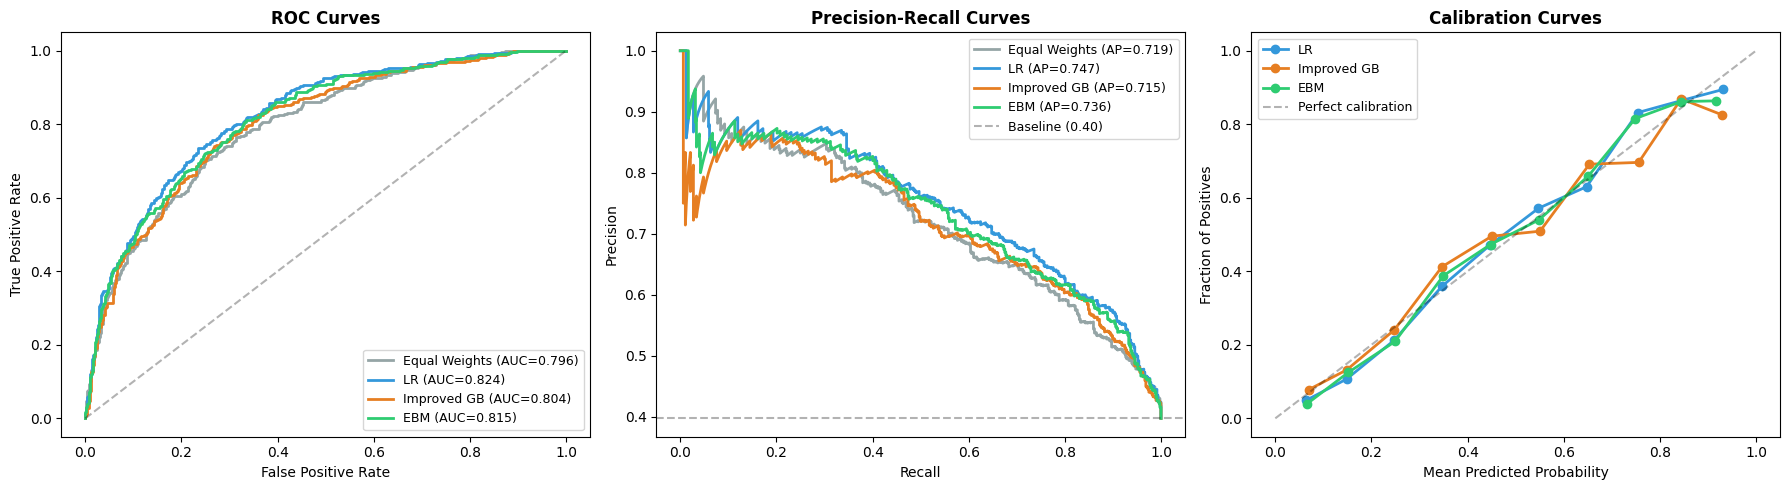

In [7]:
COLOR_LR = '#3498db'
COLOR_GB = '#e67e22'
COLOR_EBM = '#2ecc71'
COLOR_EQ = '#95a5a6'

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax = axes[0]
for name, scores, color in [('Equal Weights', baseline_scores, COLOR_EQ),
                              ('LR', lr_probs, COLOR_LR),
                              ('Improved GB', gb_probs, COLOR_GB),
                              ('EBM', ebm_probs, COLOR_EBM)]:
    fpr, tpr, _ = roc_curve(y_valid, scores)
    auc = roc_auc_score(y_valid, scores)
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', color=color, linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves', fontweight='bold')
ax.legend(fontsize=9)

ax = axes[1]
for name, scores, color in [('Equal Weights', baseline_scores, COLOR_EQ),
                              ('LR', lr_probs, COLOR_LR),
                              ('Improved GB', gb_probs, COLOR_GB),
                              ('EBM', ebm_probs, COLOR_EBM)]:
    prec, rec, _ = precision_recall_curve(y_valid, scores)
    ap = average_precision_score(y_valid, scores)
    ax.plot(rec, prec, label=f'{name} (AP={ap:.3f})', color=color, linewidth=2)
ax.axhline(y=y_valid.mean(), color='k', linestyle='--', alpha=0.3, label=f'Baseline ({y_valid.mean():.2f})')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves', fontweight='bold')
ax.legend(fontsize=9)

ax = axes[2]
for name, probs, color in [('LR', lr_probs, COLOR_LR),
                             ('Improved GB', gb_probs, COLOR_GB),
                             ('EBM', ebm_probs, COLOR_EBM)]:
    frac_pos, mean_pred = calibration_curve(y_valid, probs, n_bins=10)
    ax.plot(mean_pred, frac_pos, marker='o', label=name, color=color, linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect calibration')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('Fraction of Positives')
ax.set_title('Calibration Curves', fontweight='bold')
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


## EBM Shape Functions

Each plot shows the learned non-linear relationship between a single feature and the model's log-odds output. These are the 'weights' — but instead of a single number per feature, you get a curve.

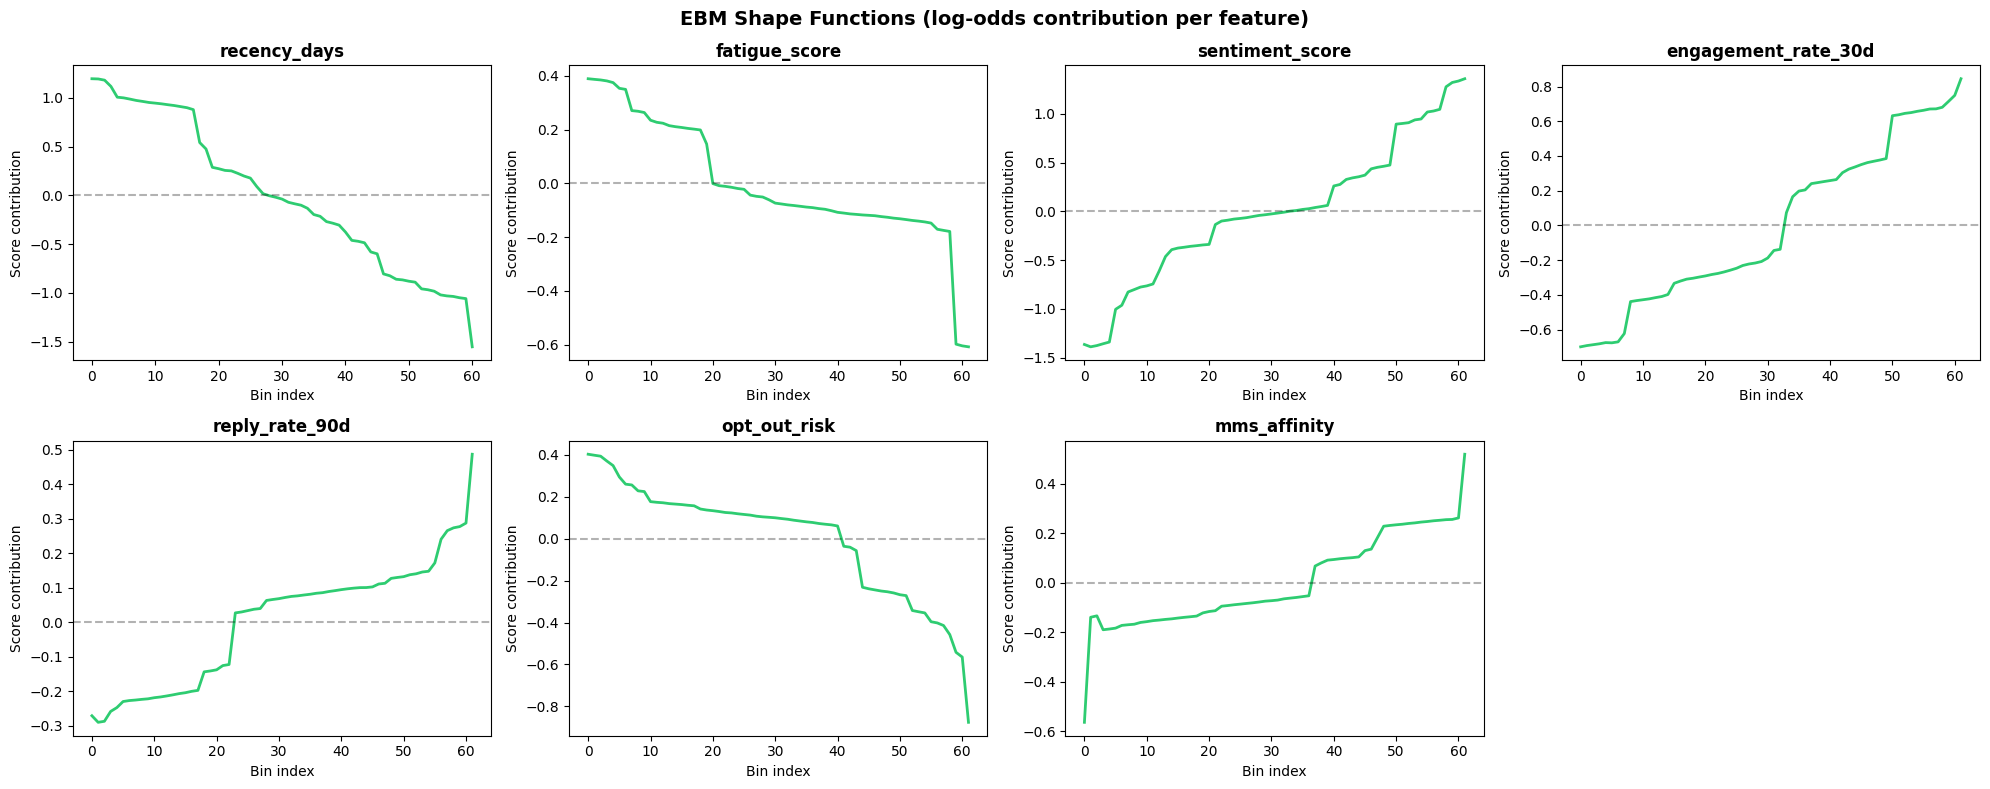

In [8]:
ebm_global = ebm_model.explain_global()
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes_flat = axes.flatten()

for i, feat in enumerate(FEATURES):
    ax = axes_flat[i]
    idx = ebm_model.term_names_.index(feat)
    bins = ebm_global.data(idx)['names']
    scores = ebm_global.data(idx)['scores']
    ax.plot(range(len(scores)), scores, color=COLOR_EBM, linewidth=2)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.set_title(feat, fontweight='bold')
    ax.set_xlabel('Bin index')
    ax.set_ylabel('Score contribution')

axes_flat[-1].axis('off')
plt.suptitle('EBM Shape Functions (log-odds contribution per feature)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()


## Feature Importance Comparison

Three views of feature importance — one per model. LR uses absolute standardized coefficients, GB uses impurity-based importance, EBM uses mean absolute score contribution across bins.

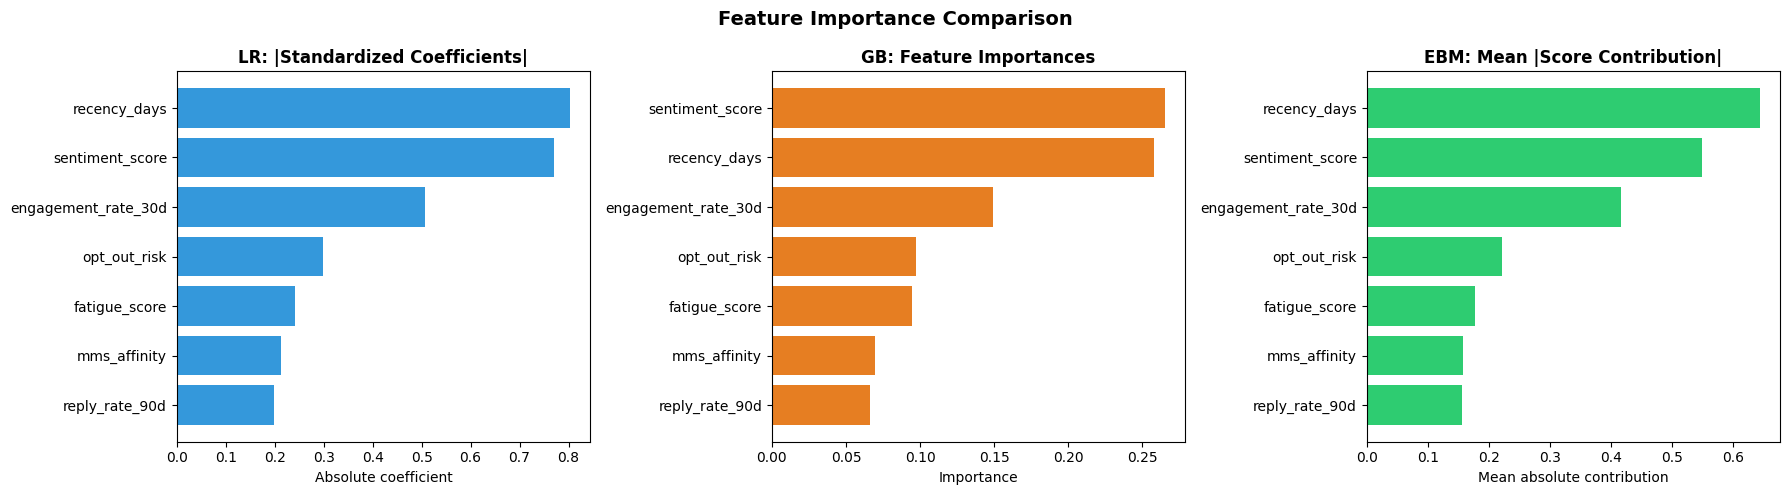

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# LR importances
lr_imp = pd.DataFrame({'feature': FEATURES, 'importance': np.abs(lr_model.coef_[0])}).sort_values('importance')
ax = axes[0]
ax.barh(lr_imp['feature'], lr_imp['importance'], color=COLOR_LR)
ax.set_title('LR: |Standardized Coefficients|', fontweight='bold')
ax.set_xlabel('Absolute coefficient')

# GB importances
gb_imp_sorted = gb_imp.sort_values('importance')
ax = axes[1]
ax.barh(gb_imp_sorted['feature'], gb_imp_sorted['importance'], color=COLOR_GB)
ax.set_title('GB: Feature Importances', fontweight='bold')
ax.set_xlabel('Importance')

# EBM importances
ebm_importances = []
for feat in FEATURES:
    idx = ebm_model.term_names_.index(feat)
    scores = ebm_global.data(idx)['scores']
    ebm_importances.append(np.mean(np.abs(scores)))
ebm_imp = pd.DataFrame({'feature': FEATURES, 'importance': ebm_importances}).sort_values('importance')
ax = axes[2]
ax.barh(ebm_imp['feature'], ebm_imp['importance'], color=COLOR_EBM)
ax.set_title('EBM: Mean |Score Contribution|', fontweight='bold')
ax.set_xlabel('Mean absolute contribution')

plt.suptitle('Feature Importance Comparison', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()


## Weight Export

Export each model's weights as CSV files for downstream use.

In [10]:
# LR weights
pd.DataFrame({
    'feature': FEATURES,
    'weight': lr_model.coef_[0]
}).to_csv('weights_lr.csv', index=False)
print('Saved weights_lr.csv')

# GB weights
pd.DataFrame({
    'feature': FEATURES,
    'importance': gb_model.feature_importances_
}).to_csv('weights_gb.csv', index=False)
print('Saved weights_gb.csv')

# EBM weights (mean absolute contribution)
pd.DataFrame({
    'feature': FEATURES,
    'mean_contribution': ebm_importances
}).to_csv('weights_ebm.csv', index=False)
print('Saved weights_ebm.csv')

# EBM shape functions (full bin lookup table)
shape_rows = []
for feat in FEATURES:
    idx = ebm_model.term_names_.index(feat)
    data = ebm_global.data(idx)
    names = data['names']
    scores = data['scores']
    for j, score in enumerate(scores):
        bin_label = str(names[j]) if j < len(names) else ''
        shape_rows.append({'feature': feat, 'bin': bin_label, 'score_contribution': score})

pd.DataFrame(shape_rows).to_csv('ebm_shape_functions.csv', index=False)
print('Saved ebm_shape_functions.csv')
print(f'Shape function table: {len(shape_rows)} rows')

Saved weights_lr.csv
Saved weights_gb.csv
Saved weights_ebm.csv
Saved ebm_shape_functions.csv
Shape function table: 433 rows


## SQL Deployment Example

EBM shape functions can be deployed as `CASE WHEN` lookup tables in SQL. Here's an example for one feature:

```sql
-- Example: engagement_rate_30d shape function as SQL CASE WHEN
SELECT
  customer_id,
  CASE
    WHEN engagement_rate_30d < 0.1 THEN -0.234
    WHEN engagement_rate_30d < 0.2 THEN -0.156
    WHEN engagement_rate_30d < 0.3 THEN  0.012
    WHEN engagement_rate_30d < 0.4 THEN  0.089
    WHEN engagement_rate_30d < 0.5 THEN  0.145
    ELSE 0.198
  END AS engagement_score
  -- + similar CASE WHEN for each other feature
  -- + intercept
FROM leads;
```

The actual bin boundaries and scores come from `ebm_shape_functions.csv`. Each feature gets its own `CASE WHEN` block, and the final score is the sum of all contributions plus the intercept. No model server needed — pure SQL.

## Conclusion

This experiment compared four scoring approaches on the same 3,500-row train / 1,200-row validation split:

| Model | AUC-ROC | PR-AUC | Brier Score | P@100 | P@200 |
|-------|---------|--------|-------------|-------|-------|
| Equal Weights | 0.7964 | 0.7193 | 0.2193 | 0.85 | 0.815 |
| **Logistic Regression** | **0.8244** | **0.7472** | **0.1664** | **0.86** | **0.835** |
| Improved GB | 0.8035 | 0.7145 | 0.1755 | 0.86 | 0.790 |
| EBM | 0.8146 | 0.7355 | 0.1707 | 0.86 | 0.830 |

### Key findings

1. **LR wins across the board.** Logistic Regression achieves the best AUC-ROC (0.8244), PR-AUC (0.7472), Brier Score (0.1664), and P@200 (0.835). The signal in this dataset is predominantly linear — a single weight per feature captures most of the predictive information.

2. **EBM is a solid second.** EBM outperforms the Improved GB on every metric (AUC-ROC 0.8146 vs 0.8035, PR-AUC 0.7355 vs 0.7145) and comes close to LR. The ~1 percentage point AUC gap vs LR suggests mild non-linearities exist but don't add much lift on 3,500 rows.

3. **Improved GB underperforms.** Even with anti-overfitting hyperparameters (shallower trees, slower learning rate, leaf regularization), GB still trails both LR and EBM. Tree ensembles need more data to outperform additive models on small tabular datasets.

4. **EBM shape functions are revealing.** The shape plots show that `recency_days` and `sentiment_score` have the strongest effects, consistent with LR's largest coefficients. Most shapes are roughly monotonic, confirming the linear signal dominance — but some features (e.g., `engagement_rate_30d`) show subtle non-linear kinks that LR cannot capture.